# Trabajo practica N°2: Computer Vision

Integrantes:

- Diego Zabala
- Federico Henzenn
- Jose Pron

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2


/home/fede/Documentos/Machine-learning/PT-1/tp1_exploration/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PICTURE_SIZE = 45
CHANNELS = 'rgb'

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i)
                          for i in range(PICTURE_SIZE ** 2)])
columnas=list(range(0,PICTURE_SIZE*PICTURE_SIZE*3))

In [3]:
def load_images(path):
    img_data = []
    labels = []
    idx_to_label = []
    i = -1
    for fruit in os.listdir(path):
        fruit_path = os.path.join(path,fruit)
        labels.append(fruit)
        i = i+1
        for img in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path,img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (PICTURE_SIZE, PICTURE_SIZE))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img_data.append(image)
            idx_to_label.append(i)
    return np.array(img_data),np.array(idx_to_label),labels

In [4]:
def show_images(samples):
    for index, sample in samples.iterrows():

        sample_as_grid = sample[columnas].values.reshape(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)).astype(np.float)
        sample_as_grid = sample_as_grid / 255
        
        plt.axis('off')
        plt.imshow(sample_as_grid, interpolation='nearest')

        plt.show()

In [5]:
def extract_inputs(dataset,redC):
    """
    Extrae del conjunto de datos original solo las 
    columnas que se deben utilizar como entrada. 
    """
    if redC==False:
        # estandarización rápida y simple: dividir todo por 255 :)
        return dataset[columnas].values / 255
    else:
        return dataset[columnas].values.reshape(len(dataset), PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255


def extract_outputs(dataset):
    """
    Extrae del conjunto de datos original solo la 
    columna que se debe utilizar como salida y retorna
    tantas columnas como etiquetas distintas existan.
    Por ejemplo, podríamos pensar que las columnas resultantes
    serían: es_fisa, es_gabi, es_mariano.
    """
    is_fruit_columns = [(dataset.etiqueta == fruit).values for fruit in label_data]
    return np.array(is_fruit_columns).T

In [6]:
def add_predictions(dataset,redC):

    predictions = model.predict(extract_inputs(dataset,redC))

    for fruit_number, fruit in enumerate(label_data):
        dataset[fruit] = predictions[:, fruit_number]
    
    dataset['prediction'] = dataset[label_data].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[label_data].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.etiqueta

Se lee la las imagenes del set de datos en la carpeta data/

In [7]:
training_data_path = 'data/Training/'
validation_data_path = 'data/Validation/'
X_train,y_train,label_data = load_images(training_data_path)
X_test,y_test,label_data_garbage = load_images(validation_data_path)

In [8]:
X_train[0].shape

(45, 45, 3)

## DataSet

Se redimenciona el array en un DataFrame, teniendo en cuenta que las columnas seran por cada pixel R G B por 45 pixel de ancho por 45 largo y luego la etiqueta de la fruta. 

In [9]:
train_rearmado=X_train.reshape(len(y_train),-1)#Rearma el array en dos dimensiones 

trainDF=pd.DataFrame(data=train_rearmado) 

etiqueta=pd.Series(data=y_train) #crea una serie con el index de las imagenes y el index de las etiquetas

etiqueta=etiqueta.replace({v: k for v, k in enumerate(label_data)},)#remplaza el index de las etiquetas con nombre de las mismas


trainDF['etiqueta']=etiqueta
print(trainDF.shape)

(33657, 6076)


In [10]:
trainDF.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,6066,6067,6068,6069,6070,6071,6072,6073,6074,etiqueta
12097,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Pear Monster
33084,254,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Grapefruit Pink
8668,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Raspberry
650,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Strawberry
27766,254,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,Apple Red 3


In [11]:
test_rearmado=X_test.reshape(len(y_test),-1)#Rearma el array en dos dimensiones 

testDF=pd.DataFrame(data=test_rearmado) 

etiqueta=pd.Series(data=y_test) #crea una serie con el index de las imagenes y el index de las etiquetas

etiqueta=etiqueta.replace({v: k for v, k in enumerate(label_data)},)#remplaza el index de las etiquetas con nombre de las mismas


testDF['etiqueta']=etiqueta

In [12]:
train = trainDF.copy()
test = testDF.copy()

sets = (
    ('train', train),
    ('test', test),
)

Cantidad de frutas:  67
Cantidad de ejemplos en train:  33657
Cantidad de ejemplos en test:  11312
Set de datos:train


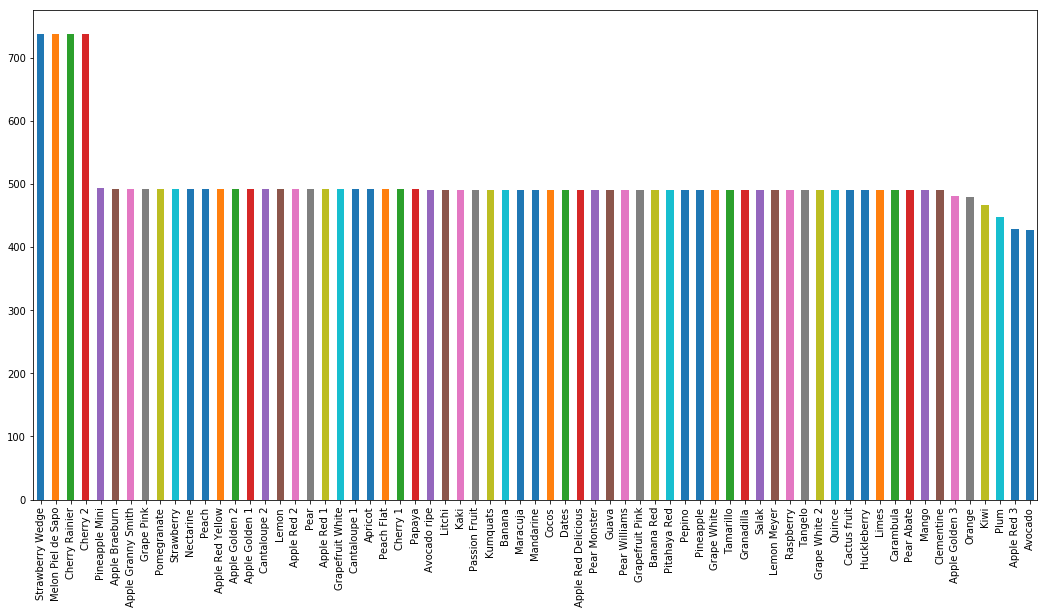

Set de datos:test


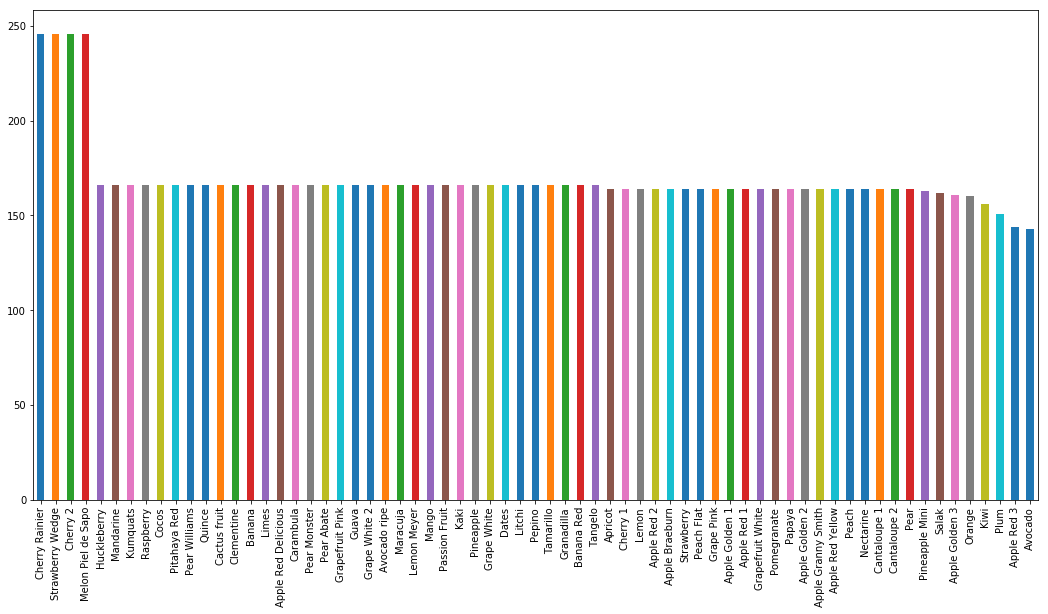

In [13]:
print('Cantidad de frutas: ',len(label_data))
print('Cantidad de ejemplos en train: ',len(y_train))
print('Cantidad de ejemplos en test: ',len(y_test))
for nameset, set in sets:
    print('Set de datos:'+ nameset)
    set.etiqueta.value_counts().plot.bar(figsize=(18,9))
    plt.show()

Ejemplos de las imagenes

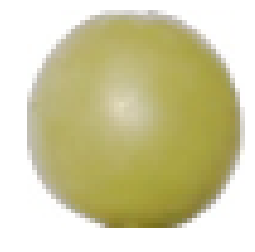

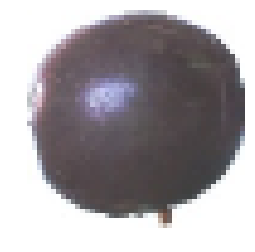

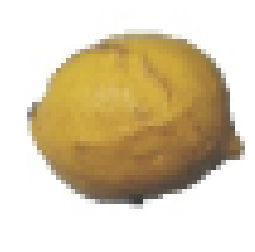

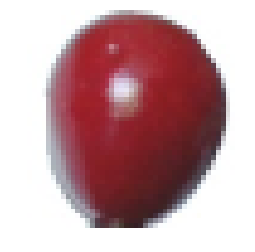

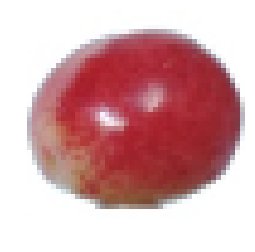

In [14]:
show_images(testDF.sample(5))

## Red neuronal de tipo MLP
Se utilizo primero una red de tipo MLP para probar la prediccion en contra de las tipos Convolución

In [19]:
model = Sequential([
    Dense(50, activation='tanh', input_shape=(len(columnas), )),
    Dense(100, activation='tanh'),    
    Dense(300, activation='tanh'),
    Dense(100, activation='tanh'),
    Dropout(0.2),
    Dense(50, activation='tanh'),
    Dropout(0.2),

    Dense(len(label_data), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [20]:
history = model.fit(
    extract_inputs(train,False), 
    extract_outputs(train), 
    epochs=5,
    batch_size=128,
    validation_data=(
        extract_inputs(test,False),
        extract_outputs(test),
    )
)

Train on 33657 samples, validate on 11312 samples
Epoch 1/5
33657/33657 [==============================] - 28s 824us/step - loss: 2.7584 - acc: 0.2661 - val_loss: 1.8485 - val_acc: 0.4970
Epoch 2/5
33657/33657 [==============================] - 27s 805us/step - loss: 1.3760 - acc: 0.6039 - val_loss: 1.2090 - val_acc: 0.6573
Epoch 3/5
33657/33657 [==============================] - 27s 811us/step - loss: 0.9477 - acc: 0.7230 - val_loss: 0.9693 - val_acc: 0.7122
Epoch 4/5
33657/33657 [==============================] - 27s 807us/step - loss: 0.7461 - acc: 0.7737 - val_loss: 0.9552 - val_acc: 0.7323
Epoch 5/5
33657/33657 [==============================] - 28s 831us/step - loss: 0.6266 - acc: 0.8053 - val_loss: 1.0353 - val_acc: 0.6803


######################### train #########################
accuracy 0.8266928127878301


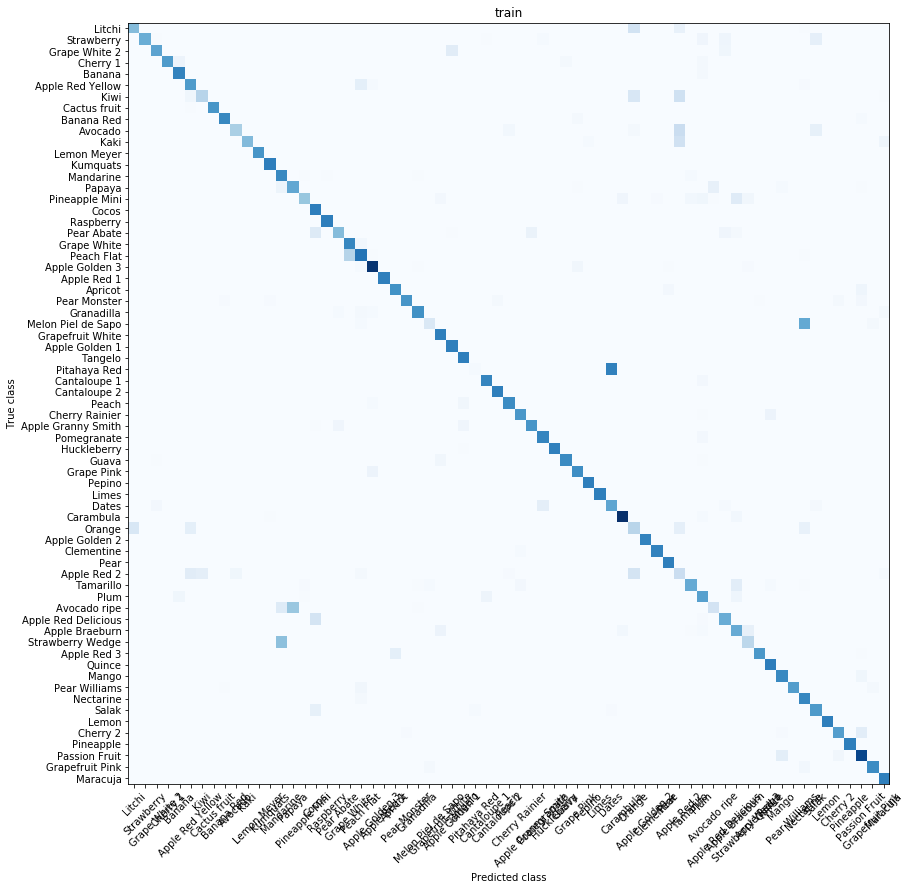

######################### test #########################
accuracy 0.6802510608203678


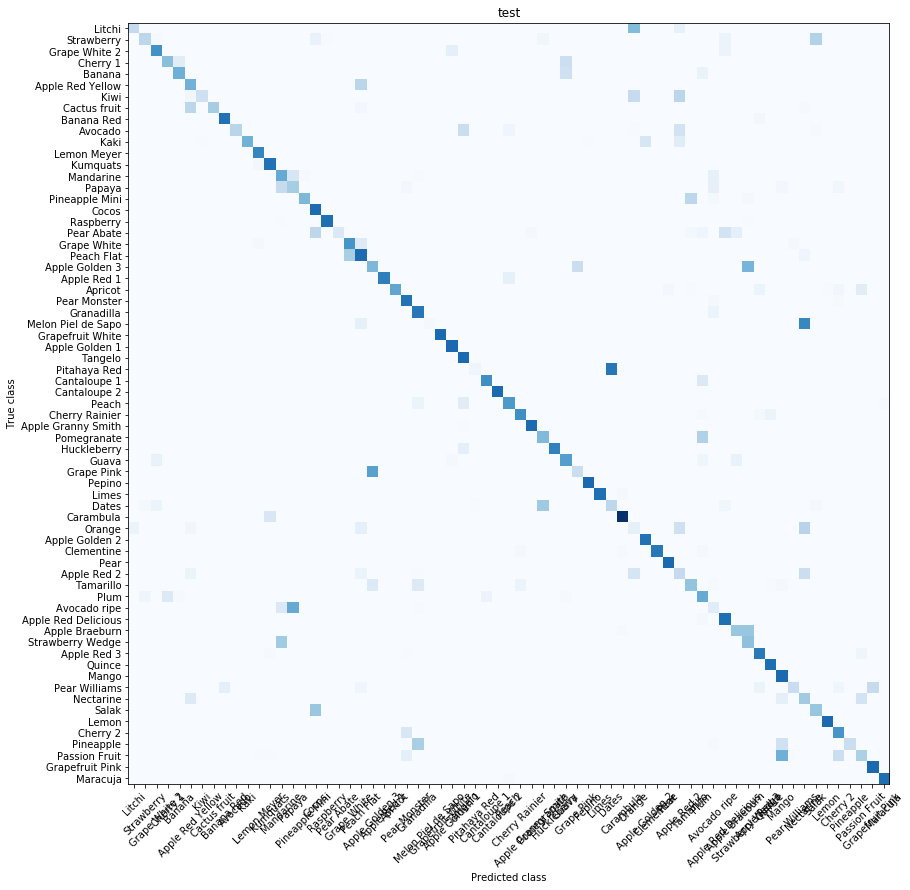

In [21]:
for set_name, set_data in sets:
    add_predictions(set_data,False)
    
    print('#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(set_data.etiqueta, set_data.prediction))

        
    plt.figure(figsize=(15,14))
        
    plt.xticks(list(range(67)), label_data, rotation=45)
    plt.yticks(list(range(67)), label_data)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.etiqueta, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

Se puede observar que la prediccion de este tipos de redes con respecto a imagenes no son efectivas

In [22]:
model = Sequential([
    Convolution2D(32, (4, 4), activation='relu', input_shape=(PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)),),
    Convolution2D(16, (4, 4), activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='tanh'),    
    Dense(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='tanh'),
    Dropout(0.2),

    Dense(len(label_data), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [23]:
history = model.fit(
    extract_inputs(train,True), 
    extract_outputs(train), 
    epochs=5,
    batch_size=128,
    validation_data=(
        extract_inputs(test,True),
        extract_outputs(test),
    )
)

Train on 33657 samples, validate on 11312 samples
Epoch 1/5
33657/33657 [==============================] - 304s 9ms/step - loss: 2.8852 - acc: 0.3372 - val_loss: 1.7585 - val_acc: 0.7375
Epoch 2/5
33657/33657 [==============================] - 307s 9ms/step - loss: 1.3574 - acc: 0.7617 - val_loss: 0.8445 - val_acc: 0.8741
Epoch 3/5
33657/33657 [==============================] - 306s 9ms/step - loss: 0.7337 - acc: 0.8894 - val_loss: 0.5005 - val_acc: 0.8971
Epoch 4/5
33657/33657 [==============================] - 306s 9ms/step - loss: 0.4362 - acc: 0.9380 - val_loss: 0.3345 - val_acc: 0.9251
Epoch 5/5
33657/33657 [==============================] - 303s 9ms/step - loss: 0.2915 - acc: 0.9599 - val_loss: 0.2466 - val_acc: 0.9468


######################### train #########################
accuracy 0.9873726119380812


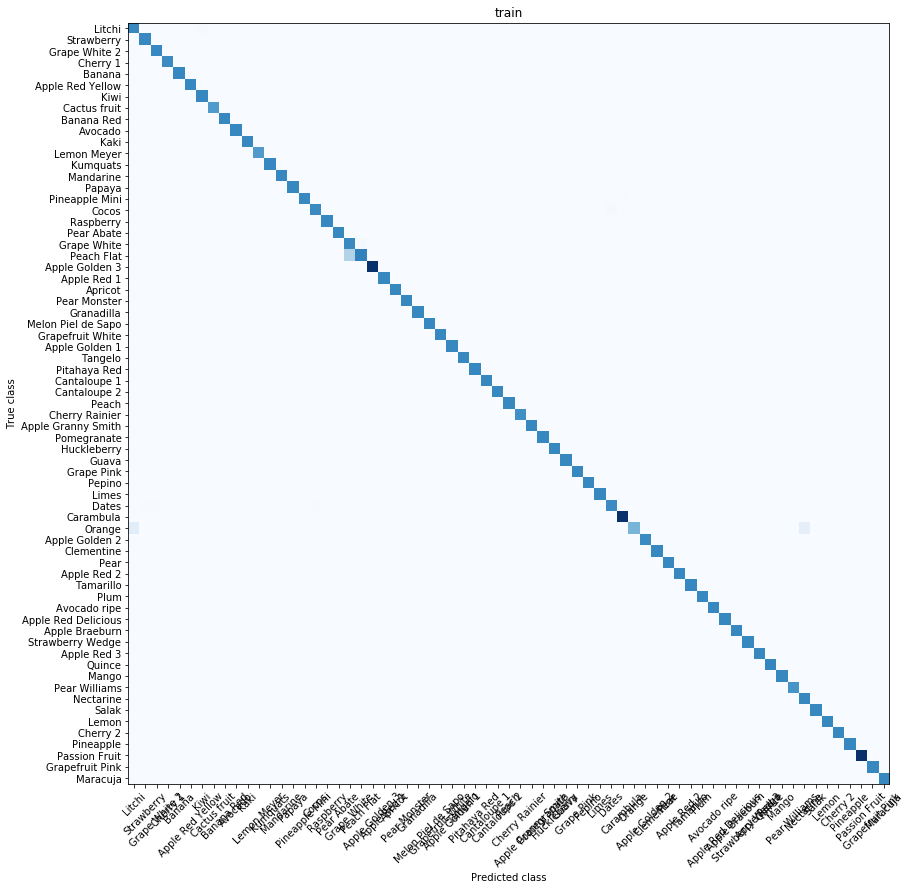

######################### test #########################
accuracy 0.9467821782178217


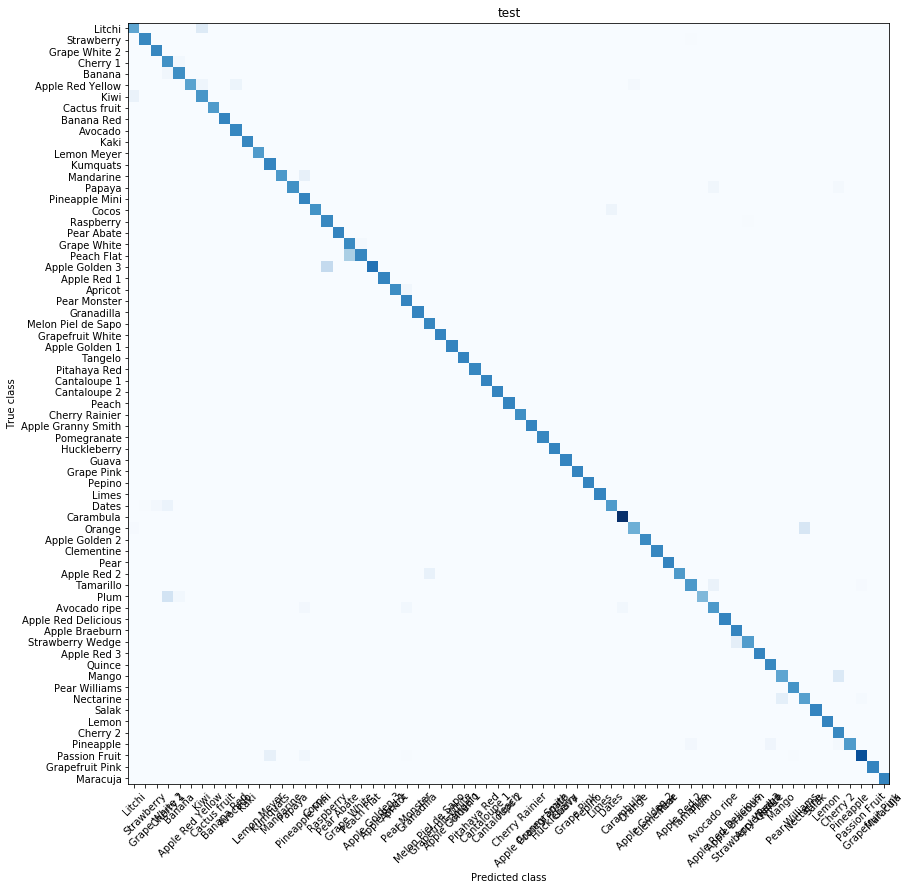

In [24]:
for set_name, set_data in sets:
    add_predictions(set_data,True)
    
    print('#' * 25, set_name, '#' * 25)
    print('accuracy', accuracy_score(set_data.etiqueta, set_data.prediction))

        
    plt.figure(figsize=(15,14))
        
    plt.xticks(list(range(67)), label_data, rotation=45)
    plt.yticks(list(range(67)), label_data)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.title(set_name)

    plt.imshow(
        confusion_matrix(set_data.etiqueta, set_data.prediction), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

## Conclusion
Se puede observar que el acurracy de la red Convolucional fue mayor que la red MLP, aunque el tiempo de entrenamiento fue mucho mayor, de unos 30s por iteracion en MLP a 300s en convolucional.